In [143]:
import pandas as pd
from finvizfinance.screener.overview import Overview
import yfinance as yf
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report

In [86]:
criteria = Overview()

In [87]:
# Criteria Set from CANSLIM method
filters_dic = {'Price':'Over $5', 'EPS growthqtr over qtr':'Over 20%', 'EPS growthpast 5 years':'Over 15%', 'InstitutionalOwnership':'Under 90%', 
               'Return on Equity':'Over +15%', '52-Week High/Low':'0-10% below High', 'Shares Outstanding': 'Under 50M', 'Price': 'Over $5', 'Average Volume': 'Over 100K'}

In [88]:
criteria.set_filter(filters_dict=filters_dic)

In [89]:
screened_stocks_df = criteria.screener_view()

In [90]:
screened_stocks_df

,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
0,CLFD,"Clearfield, Inc.",Technology,Communication Equipment,USA,1.160000e+09,41.23,97.00,-0.0157,315706.0
1,CVLG,"Covenant Logistics Group, Inc.",Industrials,Trucking,USA,5.284900e+08,6.86,33.80,0.0099,99162.0
2,GLP,Global Partners LP,Energy,Oil & Gas Midstream,USA,9.253500e+08,12.22,28.17,0.0139,53395.0
3,MGPI,"MGP Ingredients, Inc.",Consumer Defensive,Packaged Foods,USA,2.300000e+09,20.83,105.86,0.0065,36912.0
4,MUSA,Murphy USA Inc.,Consumer Cyclical,Specialty Retail,USA,6.230000e+09,13.04,283.65,-0.0025,226033.0
5,OTTR,Otter Tail Corporation,Utilities,Utilities - Diversified,USA,2.820000e+09,13.47,71.27,0.0142,58856.0
6,SRTS,"Sensus Healthcare, Inc.",Healthcare,Medical Devices,USA,1.779100e+08,8.76,11.00,-0.0231,121981.0
7,USAK,"USA Truck, Inc.",Industrials,Trucking,USA,2.806200e+08,8.19,31.17,-0.0003,67920.0


In [91]:
tickers = list(screened_stocks_df.Ticker)
tickers

['CLFD', 'CVLG', 'GLP', 'MGPI', 'MUSA', 'OTTR', 'SRTS', 'USAK']

In [124]:
yf_data = yf.download(tickers, '2021-01-01','2022-07-30')

[*********************100%***********************]  8 of 8 completed


In [125]:
df_close = yf_data["Close"]
df_close

,CLFD,CVLG,GLP,MGPI,MUSA,OTTR,SRTS,USAK
Date,,,,,,,,
2021-01-04,24.190001,14.360000,16.900000,46.689999,128.199997,41.720001,3.86,8.690000
2021-01-05,24.320000,14.910000,17.160000,48.560001,127.139999,41.490002,4.36,8.870000
2021-01-06,25.480000,15.600000,17.280001,49.389999,130.679993,43.580002,4.31,9.040000
2021-01-07,25.830000,15.730000,17.100000,49.000000,129.500000,42.919998,4.40,9.400000
2021-01-08,25.879999,15.770000,16.980000,49.070000,127.379997,42.669998,4.18,9.680000
...,...,...,...,...,...,...,...,...
2022-07-25,77.860001,29.230000,26.000000,101.440002,270.880005,66.400002,10.69,31.150000
2022-07-26,79.550003,34.509998,26.830000,103.459999,264.809998,67.599998,9.73,31.180000
2022-07-27,84.190002,33.889999,27.219999,104.629997,266.950012,67.690002,10.67,31.160000


In [126]:
df_close_cvlg = pd.DataFrame(df_close["CVLG"])
df_close_cvlg["Actual Returns"] = df_close_cvlg["CVLG"].pct_change()
df_close_cvlg.dropna().head()

,CVLG,Actual Returns
Date,,
2021-01-05,14.91,0.038301
2021-01-06,15.60,0.046278
2021-01-07,15.73,0.008333
2021-01-08,15.77,0.002543
2021-01-11,15.65,-0.007609


In [127]:
# Create features set
short_window = 25
long_window = 100
df_close_cvlg["sma_fast"] = df_close_cvlg["CVLG"].rolling(window=short_window).mean()
df_close_cvlg["sma_slow"] = df_close_cvlg["CVLG"].rolling(window=long_window).mean()
df_close_cvlg.dropna().head()

,CVLG,Actual Returns,sma_fast,sma_slow
Date,,,,
2021-05-26,22.170000,0.007727,22.2172,19.3329
2021-05-27,22.330000,0.007217,22.3188,19.4126
2021-05-28,22.510000,0.008061,22.4368,19.4886
2021-06-01,23.010000,0.022212,22.5940,19.5627
2021-06-02,22.530001,-0.020860,22.6408,19.6307


In [128]:
X = df_close_cvlg[['sma_fast', 'sma_slow']].shift().dropna().copy()
X.head()

,sma_fast,sma_slow
Date,,
2021-05-27,22.2172,19.3329
2021-05-28,22.3188,19.4126
2021-06-01,22.4368,19.4886
2021-06-02,22.5940,19.5627
2021-06-03,22.6408,19.6307


In [129]:
# Create target set
df_close_cvlg["Signal"] = 0.0

In [130]:
# Create the signal to buy
df_close_cvlg.loc[(df_close_cvlg["Actual Returns"] >= 0), "Signal"] = 1

# Create the signal to sell
df_close_cvlg.loc[(df_close_cvlg["Actual Returns"] < 0), "Signal"] = -1

In [131]:
y = df_close_cvlg["Signal"].copy()

In [133]:
# Create training datasets

training_begin = X.index.min()
training_end = X.index.min() + DateOffset(months=3)
display(training_begin)
display(training_end)

Timestamp('2021-05-27 00:00:00')

Timestamp('2021-08-27 00:00:00')

In [134]:
training_end = X.index.min() + DateOffset(months=3)
print(training_begin)

2021-05-27 00:00:00


In [135]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
Date,,
2021-05-27,22.2172,19.3329
2021-05-28,22.3188,19.4126
2021-06-01,22.4368,19.4886
2021-06-02,22.5940,19.5627
2021-06-03,22.6408,19.6307


In [136]:
# Create testing datasets

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

X_test.head()

,sma_fast,sma_slow
Date,,
2021-08-27,21.5492,21.3287
2021-08-30,21.6600,21.3543
2021-08-31,21.8516,21.3958
2021-09-01,22.0100,21.4352
2021-09-02,22.1664,21.4740


In [138]:
# Standerdize the data

scaler = StandardScaler()

In [139]:
X_scaler = scaler.fit(X_train)

In [140]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [142]:
# Create classification report

svm_model = svm.SVC()

svm_model = svm_model.fit(X_train_scaled, y_train)

training_signal_predictions = svm_model.predict(X_train_scaled)

training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [144]:

training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.61      0.42      0.50        33
         1.0       0.55      0.72      0.62        32

    accuracy                           0.57        65
   macro avg       0.58      0.57      0.56        65
weighted avg       0.58      0.57      0.56        65



In [145]:
# Backtest

testing_signal_predictions = svm_model.predict(X_test_scaled)
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.40      0.02      0.03       110
         1.0       0.52      0.98      0.68       122

    accuracy                           0.52       232
   macro avg       0.46      0.50      0.36       232
weighted avg       0.47      0.52      0.38       232



In [146]:
# Compare actual and predicted returns

predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["Predicted Signal"] = testing_signal_predictions

predictions_df["Actual Returns"] = df_close_cvlg["Actual Returns"]

predictions_df["Trading Algorithm Returns"] = (
    df_close_cvlg["Actual Returns"] * predictions_df["Predicted Signal"]
)

# Review the DataFrame
predictions_df.head()

,Predicted Signal,Actual Returns,Trading Algorithm Returns
Date,,,
2021-08-27,-1.0,0.028546,-0.028546
2021-08-30,-1.0,0.075022,-0.075022
2021-08-31,-1.0,-0.017346,0.017346
2021-09-01,-1.0,-0.007389,0.007389
2021-09-02,-1.0,0.008685,-0.008685


<AxesSubplot:xlabel='Date'>

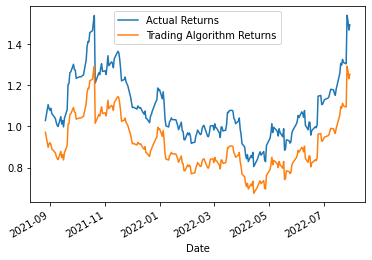

In [147]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`

(1 + predictions_df[["Actual Returns", "Trading Algorithm Returns"]]).cumprod().plot()

In [29]:
def multiply (x, y):
    
    return (x*y)

In [31]:
df_2 = []

for stock in tickers:
    z = df_close.loc[:, stock]. describe()
    x = z[["mean"]][0]
    y = z[["std"]][0]
    a = multiply(x, y)
    print(a)
    df_2.append(a)
    
df_3 = pd.DataFrame(df_2)
print(df_3)

67.50343227642583
46.586832491880116
781.1993806169914
6757.045201331392
157.49868946700227
2249.0504701932887
10.785162453630853
119.2514627170065
             0
0    67.503432
1    46.586832
2   781.199381
3  6757.045201
4   157.498689
5  2249.050470
6    10.785162
7   119.251463
